# CartoonGAN

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time 
import os
from tqdm import tqdm


# smooth target_data를 만들기 위한 전처리

In [ ]:
def make_edge_smooth(img) :
    kernel_size = 5
    img_size = 256
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gauss = cv2.getGaussianKernel(kernel_size, 0)
    gauss = gauss * gauss.transpose(1, 0)

    bgr_img = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    bgr_img = cv2.resize(bgr_img, (img_size, img_size))
    pad_img = np.pad(bgr_img, ((2, 2), (2, 2), (0, 0)), mode='reflect')
    gray_img = cv2.resize(gray_img, (img_size, img_size))

    edges = cv2.Canny(gray_img, 100, 200)
    dilation = cv2.dilate(edges, kernel)
    plt.imshow(dilation)
    gauss_img = np.copy(bgr_img)
    idx = np.where(dilation != 0)
    for i in range(np.sum(dilation != 0)):
        gauss_img[idx[0][i], idx[1][i], 0] = np.sum(
            np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 0], gauss))
        gauss_img[idx[0][i], idx[1][i], 1] = np.sum(
            np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 1], gauss))
        gauss_img[idx[0][i], idx[1][i], 2] = np.sum(
            np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 2], gauss))
    return gauss_img

In [ ]:
if os.path.isdir('smooth_data'):
    pass
else:
    os.mkdir('smooth_data')
    filenames = os.listdir('target_data')
    for filename in tqdm(filenames):
        img = cv2.imread(f'target_data/{filename}')
        img = make_edge_smooth(img)
        cv2.imwrite(f"smooth_data/{filename}",img)

# dataset 선언 및 전처리 

In [ ]:
src_ds = tf.data.Dataset.list_files('./src_data/*', shuffle=False)
orig_tgt_ds = tf.data.Dataset.list_files('./target_data/*', shuffle=False)
sms_ds = tf.data.Dataset.list_files('./smooth_data/*', shuffle=False)

In [ ]:
def src_load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256, 256])

In [ ]:
def tgt_load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [256, 256])

In [ ]:
src_ds = src_ds.map(src_load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
orig_tgt_ds = orig_tgt_ds.map(tgt_load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
sms_ds = sms_ds.map(tgt_load, num_parallel_calls=tf.data.experimental.AUTOTUNE)

src_ds = src_ds.map(lambda x: x/127.5-1)
orig_tgt_ds = orig_tgt_ds.map(lambda x: x/127.5-1)
sms_ds = sms_ds.map(lambda x: x/127.5-1)

In [ ]:
tgt_ds = tf.data.Dataset.zip((orig_tgt_ds,sms_ds))

In [ ]:
src_ds = src_ds.shuffle(400).batch(8)
tgt_ds = tgt_ds.shuffle(400).batch(8)

In [ ]:
print(len(src_ds))
print(len(tgt_ds))
len(orig_tgt_ds)
len(sms_ds)

# 모델 선언

In [2]:
class DownConvolution(tf.keras.layers.Layer):
    def __init__(self):
        super(DownConvolution,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=2,padding='same')
        self.conv2 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv3 = tf.keras.layers.Conv2D(256,kernel_size=3,strides=2,padding='same')
        self.conv4 = tf.keras.layers.Conv2D(256,kernel_size=3,strides=1,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
                   
    def call(self,input_tensor,training=False):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.bn1(x , training = training)
        x = tf.nn.relu(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.bn2(x, training= training)
        x = tf.nn.relu(x)
        return x 

In [3]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(ResidualBlock,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=1,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
               
    def call(self,input_tensor,training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training= training)
        return x + input_tensor

In [4]:
class UpConvolution(tf.keras.layers.Layer):
    def __init__(self):
        super(UpConvolution,self).__init__()
        self.trans_conv1 = tf.keras.layers.Conv2DTranspose(128,kernel_size=3,strides=2,padding='same')
        self.trans_conv2 = tf.keras.layers.Conv2DTranspose(128,kernel_size=3,strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
    
        self.trans_conv3 = tf.keras.layers.Conv2DTranspose(64,kernel_size=3,strides=2,padding='same')
        self.trans_conv4 = tf.keras.layers.Conv2DTranspose(64,kernel_size=3,strides=1,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
    
    def call(self,input_tensor,training=False):
        x = self.trans_conv1(input_tensor)
        x = self.trans_conv2(x)
        x = self.bn1(x, training = training)
        x = tf.nn.relu(x)
        
        x = self.trans_conv3(x)
        x = self.trans_conv4(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)
        return x

In [5]:
class generator(tf.keras.Model):
    def __init__(self):
        super(generator,self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(64,kernel_size=7,strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.down_conv = DownConvolution()
        
        self.residual1 = ResidualBlock()
        self.residual2 = ResidualBlock()
        self.residual3 = ResidualBlock()
        self.residual4 = ResidualBlock()
        self.residual5 = ResidualBlock()
        self.residual6 = ResidualBlock()
        self.residual7 = ResidualBlock()
        self.residual8 = ResidualBlock()
        
        self.up_conv = UpConvolution()
        
        self.conv2 = tf.keras.layers.Conv2D(3, kernel_size=7, strides=1,padding='same')
        
    def call(self,input_tensor,training=False):
        
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        
        x = self.down_conv(x)
        
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.residual3(x)
        x = self.residual4(x)
        x = self.residual5(x)
        x = self.residual6(x)
        x = self.residual7(x)
        x = self.residual8(x)
        
        x = self.up_conv(x)
        x = self.conv2(x)
        x = tf.nn.tanh(x)
        return x


In [6]:
class discriminator(tf.keras.Model):
    def __init__(self):
        super(discriminator,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32,kernel_size=3,strides=1,padding='same')
        
        self.conv2 = tf.keras.layers.Conv2D(64,kernel_size=3, strides=2, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=1, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv4 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=2,padding='same')
        self.conv5 = tf.keras.layers.Conv2D(256,kernel_size=3, strides=1, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.conv6 = tf.keras.layers.Conv2D(256,kernel_size=3, strides=1, padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()      
        
        self.conv7 = tf.keras.layers.Conv2D(1,kernel_size=3, strides=1, padding='same')
    
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv2(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv3(x)
        x = self.bn1(x, training= training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv4(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv5(x)
        x = self.bn2(x, training = training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv6(x)
        x = self.bn3(x, training= training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv7(x)
        return x    

# generator와 discriminator 선언
# model의 input size 지정 (None,None,3) 

In [18]:
disc = discriminator()
gen = generator()
input_d = tf.keras.Input(shape=(None,None,3))
output_d = disc(input_d)
d = tf.keras.Model(inputs=input_d,outputs=output_d)

input_g = tf.keras.Input(shape=(None,None,3))
output_g = gen(input_g)
g = tf.keras.Model(inputs=input_g,outputs=output_g)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
L1_loss = tf.keras.losses.MeanAbsoluteError()

def adversarial_loss(real_output, smooth_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    smooth_loss = cross_entropy(tf.ones_like(smooth_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    
    total_loss = real_loss + fake_loss + smooth_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

def content_loss(src_feature, reconstruct_feature):
    return L1_loss(src_feature, reconstruct_feature)

# 이쯤에서 데이터가 멀쩡한지 확인

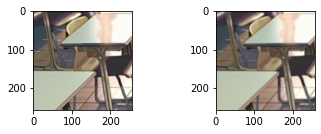

In [20]:
for i in tgt_ds.take(1):
    plt.subplot(221)
    plt.imshow(((i[0][0].numpy()+1)*127.5).astype(np.uint8))
    
    plt.subplot(222)
    plt.imshow(((i[1][0].numpy()+1)*127.5).astype(np.uint8))

# content loss를 위한 VGG19 pretrained model 가져오기 

In [4]:
vgg19 = tf.keras.applications.VGG19(weights='imagenet',input_shape=(None,None,3),include_top=False)
feature_extracter = tf.keras.Model(inputs=vgg19.input,outputs=vgg19.get_layer('block4_conv4').output)

80142336/80134624 [==============================] - 3s 0us/step


In [22]:
def VGG(input_tensor,feature_extracter):
    return feature_extracter(input_tensor)

# pretrain phase (content loss로만 10epoch 학습)

In [23]:
for epoch in range(1,11):
    pretrain_loss = 0.0
    start_time = time.time()
    for src_batch in tqdm(src_ds):
        with tf.GradientTape() as gen_tape:
            generated_img = g(src_batch, training=True)

            reconstruct_feature = VGG(generated_img,feature_extracter) 
            src_feature = VGG(src_batch,feature_extracter)

            c_loss = 10 * content_loss(reconstruct_feature,src_feature)
            pretrain_loss += c_loss

        gradients_of_generator = gen_tape.gradient(c_loss, g.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, g.trainable_variables))

    print(f'epoch : {epoch}, time : {time.time()-start_time} , pretrain_loss : {pretrain_loss}')

100%|██████████| 448/448 [03:22<00:00,  2.23it/s]


epoch : 1, time : 202.55567049980164 , pretrain_loss : 2027.904052734375


In [24]:
tf.keras.models.save_model(g,'pretrain')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pretrain/assets


# 학습
매 epoch 마다 result 이미지 출력  
generator와 discriminator weight 저장  

In [ ]:
if os.path.isdir('results'):
    pass
else:
    os.mkdir('results')

In [25]:
for epoch in range(1,2):
    start_time = time.time()
    total_loss=0.0
    total_gen_loss = 0.0
    total_adv_loss = 0.0
    for src_batch, tgt_batch in tqdm(zip(src_ds,tgt_ds)):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_img = g(src_batch, training=True)

            reconstruct_feature = VGG(generated_img,feature_extracter) 
            src_feature = VGG(src_batch,feature_extracter)

            c_loss = content_loss(reconstruct_feature,src_feature)

            fake_loss = d(generated_img,training=True)
            real_loss = d(tgt_batch[0],training=True)
            smooth_loss = d(tgt_batch[1],training=True)

            adv_loss = adversarial_loss(real_loss, smooth_loss, fake_loss)
            gen_loss = generator_loss(fake_loss)


            total_gen_loss += gen_loss + 10 * c_loss
            total_adv_loss += adv_loss
            
            total_loss += adv_loss + total_gen_loss

        gradients_of_generator = gen_tape.gradient(total_gen_loss, g.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(adv_loss, d.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, g.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, d.trainable_variables))
    total_loss = total_loss/len(src_batch)
    total_gen_loss = total_gen_loss/len(src_batch)
    total_adv_loss = total_adv_loss/len(src_batch)
    
    tf.keras.models.save_model(g,f'checkpoint/generator_{epoch}')
    tf.keras.models.save_model(d,f'checkpoint/discriminator_{epoch}')
    
    if os.path.isdir(f'results/{epoch}'):
        pass
    else:
        os.mkdir(f'results/{epoch}')

    filenames = os.listdir('src_data')
    for filename in tqdm(filenames):
        img_array = np.fromfile(f'src_data/{filename}', np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img = g((img[tf.newaxis,...]/127.5-1).astype('float32'))
        cv2.imwrite(f"results/{epoch}/{filename}",(((img[0]+1)*127.5).numpy()).astype(np.uint8))

    print(f'epoch : {epoch}, time : {time.time()-start_time} , total_loss : {total_loss} , gen_loss : {total_gen_loss} ,disc_loss : {adv_loss}')

448it [05:30,  1.36it/s]


INFO:tensorflow:Assets written to: checkpoint/generator_1/assets
INFO:tensorflow:Assets written to: checkpoint/discriminator_1/assets


100%|██████████| 3584/3584 [01:35<00:00, 31.71it/s]

epoch : 1, time : 432.70980954170227 , total_loss : 45818.9765625 , gen_loss : 191.44358825683594 ,disc_loss : 1.7147243022918701


# 결과 확인

In [26]:
img = cv2.imread('1.jpg')
new_model = tf.keras.models.load_model('checkpoint/generator_200')

In [27]:
output_img=new_model.predict(cv2.resize(img,(256,256))[tf.newaxis,...])

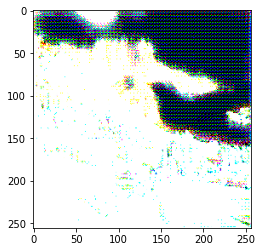

In [28]:
plt.imshow(tf.cast(output_img[0]*127.5+127.5,np.uint8))